* https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

In [2]:
# set up some imports
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
# import a progress bar using tqdm
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import requests
import zipfile
import random
import os
import shutil
from PIL import Image
from typing import Tuple, Dict, List
from torchinfo import summary
from timeit import default_timer as timer
from torchvision.transforms import v2

print(torch.cuda.is_available())
# set device to gpu if possible
targeted_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
targeted_device

c:\Users\thebl\OneDrive\Documents\Projects\dog-learn-projects\dev-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


device(type='cuda')

In [3]:
added_animals_src = []

# this code will adjust the file format of what we downloaded into neater usable categories to train our model 
import os
import shutil
import random
from pathlib import Path

# Source directory
source_dir = Path('data/cleaned_dogs_data_filtered')

# Target base directory
target_base = Path('data/master_dogs_split')  # You can change this if needed

# Split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Set random seed for reproducibility
random.seed(42)

# create the three folders
for split in ['train', 'val', 'test']:
    (target_base / split).mkdir(parents=True, exist_ok=True)

# iterates through each animal folder with the progress bar
for animal_folder in tqdm(source_dir.iterdir()):
  
  # checks to see if folder actually exists
  if animal_folder.is_dir():

    # gets folder name 
    animal_name = animal_folder.name

    # gets all the images as urls inside the folder and puts them into a list
    images = list(animal_folder.glob('*')) 


    # check  for images and removes corrupted images
    for img_path in animal_folder.rglob("*"):
      try:
        with Image.open(img_path) as img:
          img.verify()  # check for corruption
      except Exception as e:
        print(f"Deleting corrupted image: {img_path} ({e})")
        img_path.unlink()


    if (len(images) > 9):  
      # randomizes the order 
      random.shuffle(images)
  
      # count the total number of images 
      total = len(images)
  
      # last index for tain
      train_end = int(total * train_ratio)
  
      # last index for valuation
      val_end = train_end + int(total * val_ratio)
  
      # generate a image to get the indexes to split the images 60 percent to train, 20 percent to val and 20 percent to test
      split_map = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
      }
  
      for split, split_images in split_map.items():
        # the new folder url where images saved will be the base url followed by the split value (train, val, test) and followed by the animal name that we defined at the beginning of the animal folder loop
        target_dir = target_base / split / animal_name

        added_animals_src.append(target_dir)
        # create the actual folder
        target_dir.mkdir(parents=True, exist_ok=True)
        # creat the actual folder
        target_dir.mkdir(parents=True, exist_ok=True)
        
        # iterate through each image which will be represented as a string url path
        for img_path in split_images:
          # copy that image path into the targeted url path using shutil.copy(sdource, destination) method
          shutil.copy(img_path, target_dir / img_path.name)


# Save to a text file (one label per line)
with open("added_dogs.txt", "w") as f:
    for label in added_animals_src:
        f.write(f"{label}\n")

120it [01:44,  1.14it/s]


In [3]:

data_path = Path("data/")
img_path = data_path / "master_dogs_split"

train_dir = img_path / "train"
val_dir = img_path / "val"
test_dir = img_path / "test"
train_dir, val_dir

(WindowsPath('data/master_dogs_split/train'),
 WindowsPath('data/master_dogs_split/val'))

In [4]:
master_labels = []
for animal_folder in tqdm(train_dir.iterdir()):
  if animal_folder.is_dir():
    # print(f"Training folder name: {animal_folder.name}")
    master_labels.append(animal_folder.name)

# Save to a text file (one label per line)
with open("dog_labels.txt", "w") as f:
    for label in master_labels:
        f.write(f"{label}\n")


120it [00:00, 17146.44it/s]


In [ ]:
'''
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])
'''

In [5]:

manual_transforms_v2 = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL imagea
    v2.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
'''
folders = [train_dir, val_dir, test_dir]

for data_type_folders in tqdm(folders):
  # check to see if folder actually exists
  if data_type_folders.is_dir():
    #  # check  for images and removes corrupted images
    index = 0
    for animal_folder in data_type_folders.iterdir():
      for img_path in animal_folder.rglob("*"):
        try:
          with Image.open(img_path) as img:
            # if "exif" in img.info:
            #   img_data = list(img.getdata())
            #   img_without_exif = Image.new(img.mode, img.size)
            #   img_without_exif.putdata(img_data)
            #   img_without_exif.save(img_path)
            img.verify()  # check for corruption
        except Exception as e:
          print(f"Deleting corrupted image: {img_path} ({e})")
          os.unlink(img_path)
          '''

'\nfolders = [train_dir, val_dir, test_dir]\n\nfor data_type_folders in tqdm(folders):\n  # check to see if folder actually exists\n  if data_type_folders.is_dir():\n    #  # check  for images and removes corrupted images\n    index = 0\n    for animal_folder in data_type_folders.iterdir():\n      for img_path in animal_folder.rglob("*"):\n        try:\n          with Image.open(img_path) as img:\n            # if "exif" in img.info:\n            #   img_data = list(img.getdata())\n            #   img_without_exif = Image.new(img.mode, img.size)\n            #   img_without_exif.putdata(img_data)\n            #   img_without_exif.save(img_path)\n            img.verify()  # check for corruption\n        except Exception as e:\n          print(f"Deleting corrupted image: {img_path} ({e})")\n          os.unlink(img_path)\n          '

In [8]:
# load in master data label 
'''
with open("class_labels.txt", "r") as f:
    loaded_labels = [line.strip() for line in f if line.strip()]

# Map label -> index
master_class_to_idx = {label: idx for idx, label in enumerate(loaded_labels)}


len(master_class_to_idx), master_class_to_idx

'''

'\nwith open("class_labels.txt", "r") as f:\n    loaded_labels = [line.strip() for line in f if line.strip()]\n\n# Map label -> index\nmaster_class_to_idx = {label: idx for idx, label in enumerate(loaded_labels)}\n\n\nlen(master_class_to_idx), master_class_to_idx\n\n'

In [9]:
'''
def remap_label(label):
    train_data_set = datasets.ImageFolder(
    root=train_dir,
    transform=manual_transforms,
    target_transform=None,
    )
    class_name = train_data_set.classes[label]
    correct_index = master_class_to_idx[class_name]
    return correct_index

target_transforms = lambda label: remap_label(label)

'''

'\ndef remap_label(label):\n    train_data_set = datasets.ImageFolder(\n    root=train_dir,\n    transform=manual_transforms,\n    target_transform=None,\n    )\n    class_name = train_data_set.classes[label]\n    correct_index = master_class_to_idx[class_name]\n    return correct_index\n\ntarget_transforms = lambda label: remap_label(label)\n\n'

In [10]:
'''
class LabelMapper:
    def __init__(self, class_list, master_class_to_idx):
        self.class_list = class_list
        self.master_class_to_idx = master_class_to_idx

    def __call__(self, label_idx):
        label = self.class_list[label_idx]
        return self.master_class_to_idx[label]

'''

'\nclass LabelMapper:\n    def __init__(self, class_list, master_class_to_idx):\n        self.class_list = class_list\n        self.master_class_to_idx = master_class_to_idx\n\n    def __call__(self, label_idx):\n        label = self.class_list[label_idx]\n        return self.master_class_to_idx[label]\n\n'

In [6]:

# 1. load and transform data into data set

train_data_set= datasets.ImageFolder(
  root=train_dir,
  transform=manual_transforms_v2
)

# The val transform data will be simple
val_data_set = datasets.ImageFolder(
  root=val_dir,
  transform=manual_transforms_v2
)
# The test transform data will be simple
test_data_set = datasets.ImageFolder(
  root=test_dir,
  transform=manual_transforms_v2
)
# get the class names
class_names = train_data_set.classes
class_names, len(class_names)

(['affenpinscher',
  'afghan hound',
  'african hunting dog',
  'airedale',
  'american staffordshire terrier',
  'appenzeller',
  'australian terrier',
  'basenji',
  'basset',
  'beagle',
  'bedlington terrier',
  'bernese mountain dog',
  'black-and-tan coonhound',
  'blenheim spaniel',
  'bloodhound',
  'bluetick',
  'border collie',
  'border terrier',
  'borzoi',
  'boston bull',
  'bouvier des flandres',
  'boxer',
  'brabancon griffon',
  'briard',
  'brittany spaniel',
  'bull mastiff',
  'cairn',
  'cardigan',
  'chesapeake bay retriever',
  'chihuahua',
  'chow',
  'clumber',
  'cocker spaniel',
  'collie',
  'curly-coated retriever',
  'dandie dinmont',
  'dhole',
  'dingo',
  'doberman',
  'english foxhound',
  'english setter',
  'english springer',
  'entlebucher',
  'eskimo dog',
  'flat-coated retriever',
  'french bulldog',
  'german shepherd',
  'german short-haired pointer',
  'giant schnauzer',
  'golden retriever',
  'gordon setter',
  'great dane',
  'great pyren

In [12]:
'''
# 1. load and transform data into data set
data_set = datasets.ImageFolder(
    root=train_dir,
    transform=manual_transforms,
)

train_data_set = datasets.ImageFolder(
    root=train_dir,
    transform=manual_transforms,
    target_transform=LabelMapper(data_set.classes, master_class_to_idx)
)
val_data_set = datasets.ImageFolder(
    root=val_dir,
    transform=manual_transforms,
    target_transform=LabelMapper(data_set.classes, master_class_to_idx)
)

test_data_set = datasets.ImageFolder(
    root=test_dir,
    transform=manual_transforms,
   target_transform=LabelMapper(data_set.classes, master_class_to_idx)
)

# get the class names
class_names = train_data_set.classes

len(class_names), class_names
'''

'\n# 1. load and transform data into data set\ndata_set = datasets.ImageFolder(\n    root=train_dir,\n    transform=manual_transforms,\n)\n\ntrain_data_set = datasets.ImageFolder(\n    root=train_dir,\n    transform=manual_transforms,\n    target_transform=LabelMapper(data_set.classes, master_class_to_idx)\n)\nval_data_set = datasets.ImageFolder(\n    root=val_dir,\n    transform=manual_transforms,\n    target_transform=LabelMapper(data_set.classes, master_class_to_idx)\n)\n\ntest_data_set = datasets.ImageFolder(\n    root=test_dir,\n    transform=manual_transforms,\n   target_transform=LabelMapper(data_set.classes, master_class_to_idx)\n)\n\n# get the class names\nclass_names = train_data_set.classes\n\nlen(class_names), class_names\n'

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Turn images into data loaders
train_dataloader = DataLoader(
  dataset=train_data_set,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=NUM_WORKERS,
  pin_memory=True,
)

val_dataloader = DataLoader(
  dataset=val_data_set,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=NUM_WORKERS,
  pin_memory=True,
)

test_dataloader = DataLoader(
  dataset=test_data_set,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=NUM_WORKERS,
  pin_memory=True,
)

In [ ]:
'''
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights 
model_0 = torchvision.models.efficientnet_b1(weights=weights).to(targeted_device)
 
num_features = model_0.classifier[1].in_features
model_0.classifier[1] = nn.Linear(in_features=num_features, out_features=len(class_names))  
'''


In [8]:

weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
model_0 = torchvision.models.efficientnet_b2(weights=weights).to(targeted_device)

num_features = model_0.classifier[1].in_features
model_0.classifier[1] = nn.Linear(in_features=num_features, out_features=len(class_names))


In [11]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 120]            --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.0001)

In [13]:
# Train the model 
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device=targeted_device
               ):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    return train_loss, train_acc

In [14]:
# creat the test step
def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device = targeted_device
              ):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(data_loader)
    test_acc = test_acc / len(data_loader)
    return test_loss, test_acc

In [15]:
# Create a train function to call both the train and test 

def train(
  model: nn.Module,
  train_dataloader: torch.utils.data.DataLoader,
  test_dataloader: torch.utils.data.DataLoader,
  loss_fn: nn.Module,
  optimizer: torch.optim.Optimizer,
  epochs: int = 3,
  device=targeted_device
):
  # create results dictionary 
  results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
      model=model,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device
    )

    val_loss, val_acc = test_step(
      model=model,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      device=device
    )
    # print out the epoch
    print(f"Epoch: {epoch} | train loss: {train_loss:.4f} | train acc: {train_acc:.4f} | val loss: {val_loss:.4f} | val accuracy: {val_acc:.4f}")

    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(val_acc.item() if isinstance(val_loss, torch.Tensor) else val_loss)
    results["test_acc"].append(val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc)

  return results


cumulative_results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }


In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=6,
                       device=targeted_device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 17%|█▋        | 1/6 [02:46<13:54, 166.94s/it]

Epoch: 0 | train loss: 3.0326 | train acc: 0.4159 | val loss: 1.2465 | val accuracy: 0.7413


 33%|███▎      | 2/6 [05:35<11:11, 167.95s/it]

Epoch: 1 | train loss: 1.1069 | train acc: 0.7429 | val loss: 0.7128 | val accuracy: 0.7985


 50%|█████     | 3/6 [08:29<08:32, 170.79s/it]

Epoch: 2 | train loss: 0.6816 | train acc: 0.8284 | val loss: 0.5984 | val accuracy: 0.8202


 67%|██████▋   | 4/6 [11:10<05:33, 166.65s/it]

Epoch: 3 | train loss: 0.4786 | train acc: 0.8743 | val loss: 0.5618 | val accuracy: 0.8281


 83%|████████▎ | 5/6 [13:53<02:45, 165.57s/it]

Epoch: 4 | train loss: 0.3461 | train acc: 0.9089 | val loss: 0.5823 | val accuracy: 0.8141


100%|██████████| 6/6 [16:38<00:00, 166.46s/it]

Epoch: 5 | train loss: 0.2641 | train acc: 0.9346 | val loss: 0.5857 | val accuracy: 0.8210
[INFO] Total training time: 998.751 seconds


In [17]:

cumulative_results['train_loss'].extend(results['train_loss'])
cumulative_results['train_acc'].extend(results['train_acc'])
cumulative_results['test_loss'].extend(results['test_loss'])
cumulative_results['test_acc'].extend(results['test_acc'])

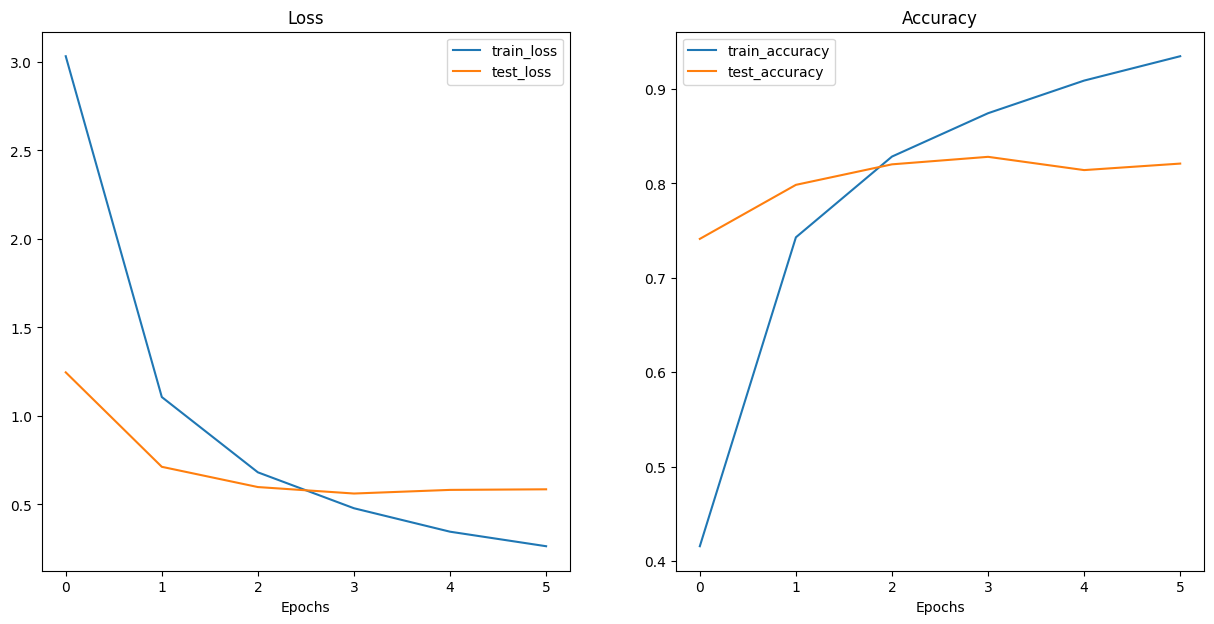

In [18]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(cumulative_results)

In [19]:
epochs = 1

for epoch in tqdm(range(epochs)):
  test_loss, test_acc = test_step(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    device=targeted_device
  )
  # print out the epoch
  print(f"Epoch: {0} | test loss: {test_loss:.4f} | test acc: {test_acc:.4f}")

100%|██████████| 1/1 [00:58<00:00, 58.08s/it]

Epoch: 0 | test loss: 0.5685 | test acc: 0.8282


In [20]:
# build a function for custom image prediction
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = targeted_device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160863..2.6400015].


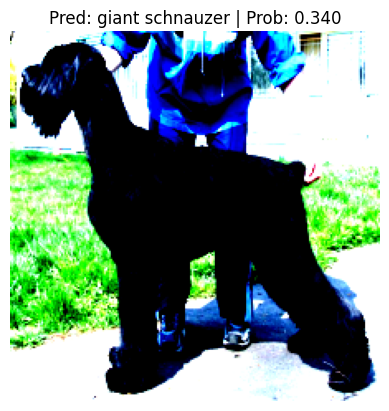

In [21]:
### SOMETHING IS WRONG WITH DATA SET 2# #####################
custom_image_path = "test_images/test_33.jpg"

# Create transform pipleine to resize image
custom_image_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL imagea
    v2.Resize((224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=targeted_device)

In [22]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("master_models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "model_0b.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: master_models\model_0b.pth
